In [43]:
import numpy as np

def generate_normal_availability(max_time, mean, std_dev, max_periods=5):
    """
    Génère des disponibilités selon une loi normale centrée autour d'un moment moyen.
    Fusionne les plages qui se chevauchent.
    """
    availability_periods = []
    num_periods = random.randint(1, max_periods)

    for _ in range(num_periods):
        start_time = int(np.clip(np.random.normal(mean, std_dev), 0, max_time - 5))
        end_time = int(np.clip(start_time + np.random.normal(3, 2), start_time + 1, max_time))
        availability_periods.append((start_time, end_time))

    return merge_intervals(availability_periods)

def merge_intervals(intervals):
    """ Fusionne les intervalles qui se chevauchent. """
    if not intervals:
        return []

    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))  # Fusion
        else:
            merged.append(current)

    return merged


📢 Affichage des disponibilités des workers avant la simulation...


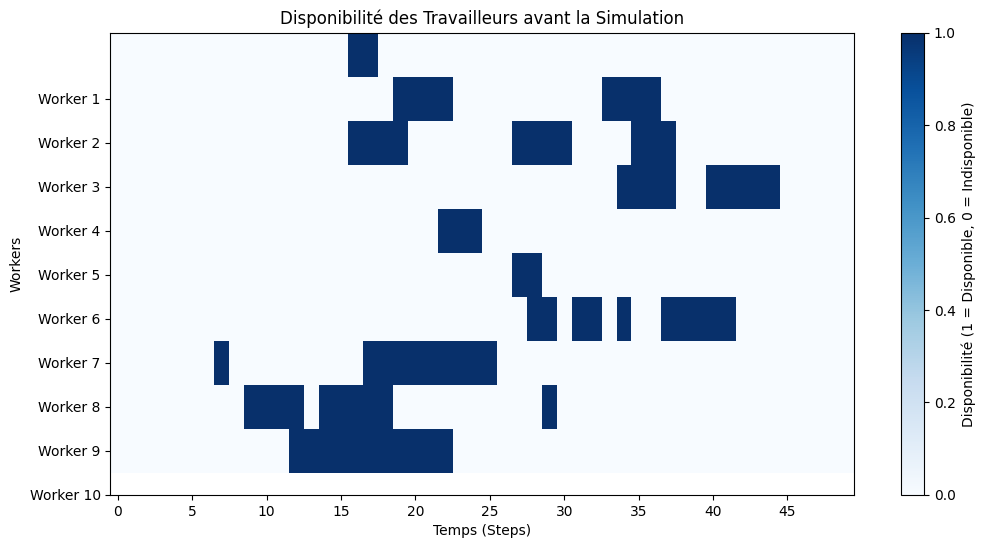

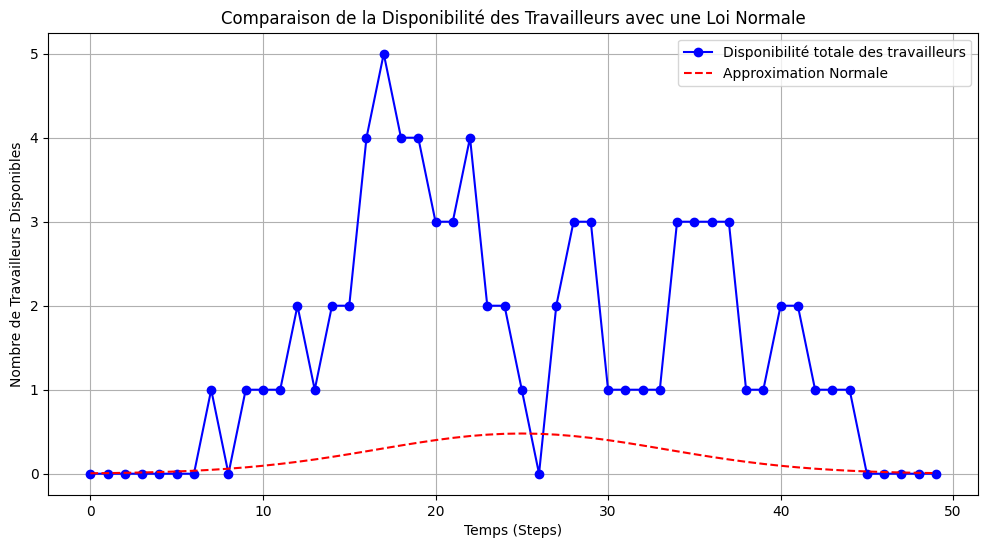

📢 Démarrage de la simulation...
🔄 Worker 1 disponible aux périodes [(16, 18)] | Temps de traitement : 2
🔄 Worker 2 disponible aux périodes [(19, 23), (33, 37)] | Temps de traitement : 4
🔄 Worker 3 disponible aux périodes [(16, 20), (27, 31), (35, 38)] | Temps de traitement : 2
🔄 Worker 4 disponible aux périodes [(34, 38), (40, 45)] | Temps de traitement : 4
🔄 Worker 5 disponible aux périodes [(22, 25)] | Temps de traitement : 4
🔄 Worker 6 disponible aux périodes [(27, 29)] | Temps de traitement : 3
🔄 Worker 7 disponible aux périodes [(28, 30), (31, 33), (34, 35), (37, 42)] | Temps de traitement : 4
🔄 Worker 8 disponible aux périodes [(7, 8), (17, 26)] | Temps de traitement : 4
🔄 Worker 9 disponible aux périodes [(9, 13), (14, 19), (29, 30)] | Temps de traitement : 4
🔄 Worker 10 disponible aux périodes [(12, 23)] | Temps de traitement : 2

⏳ Temps 0
📊 [T=0] Précision du modèle: 12.10%

⏳ Temps 1

⏳ Temps 2

⏳ Temps 3

⏳ Temps 4

⏳ Temps 5
📊 [T=5] Précision du modèle: 12.10%

⏳ Temps 6



In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torchvision import datasets, transforms
import random

# 📌 Définition du modèle de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 📌 Gestionnaire de mini-batches unique
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.sampler = RandomSampler(self.dataset)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))

    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# 📌 Classe Worker : gère le calcul local des gradients
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_id = None  # Stocke l'ID du batch sur lequel il travaille

    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False

    def start_computation(self, current_time, batch_id, data, targets):
        if self.current_batch_id is None or self.current_batch_id != batch_id:
            self.current_batch_id = batch_id
            self.finish_time = current_time + self.processing_time
            print(f"🚀 [T={current_time}] Worker {self.worker_id} commence un NOUVEAU calcul sur batch {batch_id}.")
            return self.compute_gradient(data, targets)
        return None

    def has_finished(self, current_time):
        return self.finish_time == current_time

    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_id

    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# 📌 Serveur central : gère l'application des gradients
class Server:
    def __init__(self, dataset, batch_size=64, lr=0.001):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.current_batch = None
        self.current_batch_id = 0
        self.model_updated = True  # Indique si un nouveau batch doit être pris

    def update_global_model(self, worker_gradients, batch_id):
        """Applique les gradients seulement si le batch est encore en cours de traitement."""
        if worker_gradients is None or batch_id != self.current_batch_id:
            print(f"🚨 Ignoré: Batch {batch_id} déjà traité.")
            return

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = worker_gradients[name]
        self.optimizer.step()
        print(f"🔄 Modèle mis à jour avec Batch {batch_id}.")
        
        # Maintenant, le serveur peut prendre un nouveau batch
        self.model_updated = True

    def get_batch_for_worker(self):
        """Renvoie toujours le même batch tant que le modèle n'a pas été mis à jour."""
        if self.model_updated:
            self.current_batch = self.batch_manager.get_next_batch()
            self.current_batch_id += 1
            self.model_updated = False  # Bloque la génération de nouveaux batches
        return self.current_batch, self.current_batch_id

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

# 📌 Simulation d'apprentissage fédéré
# 📌 Ajout de la méthode `plot_worker_availability()` dans la classe `DiscreteEventSimulator`
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=20):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.worker_computing = []

    def plot_worker_availability(self):
        """ Affiche la disponibilité des workers avant la simulation et la disponibilité totale par step. """
        num_workers = len(self.workers)
        total_time_steps = self.total_time_steps

        availability_data = [(worker.worker_id, worker.availability_periods) for worker in self.workers]
        time_grid = np.zeros((num_workers, total_time_steps))
        for worker_id, periods in availability_data:
            for start, end in periods:
                time_grid[worker_id - 1, start:end] = 1

        # 📌 Affichage des disponibilités sous forme de heatmap
        plt.figure(figsize=(12, 6))
        plt.imshow(time_grid, aspect="auto", cmap="Blues", interpolation="nearest")
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Workers")
        plt.title("Disponibilité des Travailleurs avant la Simulation")
        plt.xticks(range(0, total_time_steps, max(1, total_time_steps // 10)))
        plt.yticks(range(1, num_workers + 1), [f"Worker {i}" for i in range(1, num_workers + 1)])
        plt.colorbar(label="Disponibilité (1 = Disponible, 0 = Indisponible)")
        plt.show()

        # 📌 Calculer la disponibilité totale des travailleurs à chaque step
        availability_counts = np.sum(time_grid, axis=0)

        # 📌 Génération d'une distribution normale pour comparaison
        mean_time = total_time_steps / 2
        std_dev_time = total_time_steps / 6
        x = np.arange(total_time_steps)
        normal_distribution = num_workers * (1 / (std_dev_time * np.sqrt(2 * np.pi))) * np.exp(-((x - mean_time) ** 2) / (2 * std_dev_time ** 2))

        # 📌 Affichage de la disponibilité totale en fonction du temps
        plt.figure(figsize=(12, 6))
        plt.plot(x, availability_counts, marker='o', linestyle='-', label="Disponibilité totale des travailleurs", color='blue')
        plt.plot(x, normal_distribution, linestyle='--', label="Approximation Normale", color='red')
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Nombre de Travailleurs Disponibles")
        plt.title("Comparaison de la Disponibilité des Travailleurs avec une Loi Normale")
        plt.legend()
        plt.grid()
        plt.show()

    def run(self):
        """ Démarre la simulation avec affichage des disponibilités des workers. """
        print("📢 Affichage des disponibilités des workers avant la simulation...")
        self.plot_worker_availability()

        print("📢 Démarrage de la simulation...")

        for worker in self.workers:
            print(f"🔄 Worker {worker.worker_id} disponible aux périodes {worker.availability_periods} | Temps de traitement : {worker.processing_time}")

        while self.global_time < self.total_time_steps:
            print(f"\n⏳ Temps {self.global_time}")

            newly_finished_workers = [worker for worker in self.worker_computing if worker.has_finished(self.global_time)]

            for worker in newly_finished_workers:
                self.worker_computing.remove(worker)
                batch, _ = self.server.get_batch_for_worker()
                data, targets = batch
                gradients, batch_id = worker.compute_gradient(data, targets)
                self.server.update_global_model(gradients, batch_id)

            available_workers = [worker for worker in self.workers if worker.is_available(self.global_time) and worker not in self.worker_computing]

            for worker in available_workers:
                batch, batch_id = self.server.get_batch_for_worker()
                data, targets = batch
                worker.start_computation(self.global_time, batch_id, data, targets)
                self.worker_computing.append(worker)

            if self.global_time % 5 == 0:
                accuracy = self.server.evaluate(self.test_loader)
                print(f"📊 [T={self.global_time}] Précision du modèle: {accuracy:.2f}%")

            self.global_time += 1

        print("🏁 Simulation terminée !")



# 📌 Chargement des données
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 📌 Initialisation
server = Server(train_dataset)
workers = [Worker(server.model, server.device, i, generate_normal_availability(50, mean=random.randint(10, 40), std_dev=6), random.randint(2, 4)) for i in range(1, 11)]

# 📌 Lancement de la simulation avec 50 steps
simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=50)
simulator.run()

